# Import mudules and data

In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import inv, norm, det
from scipy.spatial.distance import pdist, squareform

import matplotlib
from matplotlib import pyplot as plt
from multiprocessing import Pool
import time

In [2]:
import sampler.dpp as dpp
import sampler.mcdpp as mcdpp
import sampler.utils as utils
import sampler.sadpp as sadpp
import sampler.greedy as greedy

import helper.helper as helper

In [3]:
sigma2_0 = 0.4
nTrn = 4000
nTot = 5000
data = pd.read_csv('data/ailerons.txt')[:nTot].values
trnY = data[:nTrn, -1]
tstY = data[nTrn:, -1]
pairwise_dists = squareform(pdist(data[:,:-1], 'euclidean'))
L_0 = np.exp(-pairwise_dists ** 2 / 100 ** 2)
trnL_0 = L_0[:nTrn, :nTrn]

# Full GP

In [4]:
# find optimal hyperparameter for Gaussian Process
# and return kernel matrix and so on
[sigma2, L, trnL, Y_hat_full, Var_Y_hat_full, MSE_full_trn, MSE_full_tst]\
    = helper.full_GP(sigma2_0, nTrn, nTot, data, trnY, tstY)

In [5]:
sigma2

9.006578963627065e-08

# Nystrom GP

In [6]:
# size of landmark point "k"
k_group = [20,30,50,70,100,150,200,250,300]
sampling_methods = ["unif", "mcdpp", "sadpp", "greedy"]

# score_type is hard-coded in helper.py
score_types = ["logdet", "matrix error", "in-sample MSE", "out-of-sample MSE", 
                   "in-sample KL", "out-of-sample KL", "time"]  

In [7]:
def simulate_once(i):
    
    np.random.seed(i)
    
    results = {}
    for score_type in score_types:
        results[score_type] = pd.DataFrame(columns=sampling_methods, index = k_group)
    # "results" can be indexed like:
    # results["det"]["mcdpp"][150]
    # here, 150 is size landmark points
    
    samplers = {
        "unif": (lambda : np.random.permutation(nTrn)[:k]), 
        "greedy": (lambda : greedy.sample(k, k//5, 100, trnL, trnY, nTrn, sigma2)),
        "mcdpp": (lambda : mcdpp.sample(trnL_0, mix_step=nTrn, k=k, flag_gpu=False, silent=True)),
        "sadpp": (lambda : sadpp.sample(trnL_0, mix_step=nTrn, k=k, flag_gpu=False, silent=True, func_beta=lambda i:1+np.log(1+i)))
        }
    #For sampling normal dpp
    #D, V = utils.get_eig(trnL_0, flag_gpu=flag_gpu)
    #E = utils.get_sympoly(D, k, flag_gpu=flag_gpu)
    #smpl  = dpp.sample(D, V, E=E, k=k, flag_gpu=False)
    
    # evaluate scores for each k and for each sampling scheme
    for k_idx in range(len(k_group)):
        k = k_group[k_idx]
        
        for method in sampling_methods:
            
            start = time.time()
            smpl = samplers[method]()
            end = time.time()
            scores = helper.compute_scores(smpl, trnY, tstY, trnL, L, Y_hat_full, Var_Y_hat_full, sigma2)
            scores["time"] = end - start
            
            for score_type in score_types:
                results[score_type][method][k] = scores[score_type]
        
    return results

In [8]:
n_job = 6
with Pool(processes=6) as p:
    results = p.map(simulate_once, [i for i in range(n_job)])
    
# sequential exercution is like:
# results = []
# for i in range(n_job):
#     results.append(simulate_once[i])

In [9]:
# take average of the results
ave_results = {}
for score_type in score_types:
    ave_results[score_type] = pd.DataFrame(columns=sampling_methods, index = k_group)
    ave_results[score_type][:] = 0
    
for r in results:
    for score_type in score_types:
        ave_results[score_type] += r[score_type]/n_job

# Plot

In [10]:
%matplotlib inline

In [11]:
def plot(title, score_type, ylog_scale=False):
    plt.title(title)
    for method in sampling_methods:
        plt.plot(k_group, ave_results[score_type][method], label=method, lw=2)
    if ylog_scale:
        plt.yscale('log')
    plt.legend()

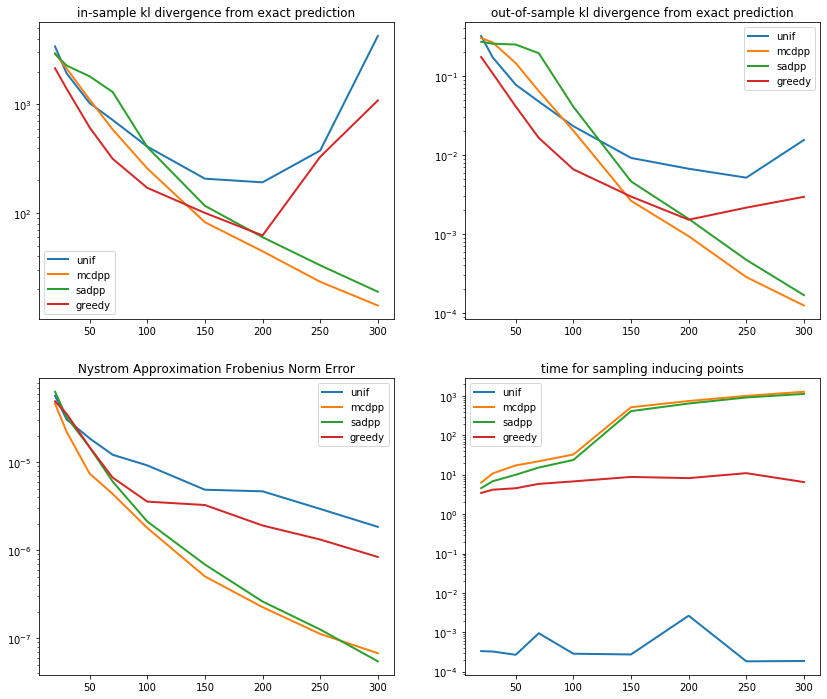

In [14]:
# plot 4 figures
plt.figure(figsize=(14,12))

plt.subplot(2,2,1)
plot('in-sample kl divergence from exact prediction', 'in-sample KL', True)

plt.subplot(2,2,2)
plot('out-of-sample kl divergence from exact prediction', 'out-of-sample KL', True)

plt.subplot(2,2,3)
plot('Nystrom Approximation Frobenius Norm Error', 'matrix error', True)

plt.subplot(2,2,4)
plot('time for sampling inducing points', 'time', True)

plt.savefig('fig/summary', bbox_inches='tight')

## Distribution of Log Eigenvalues

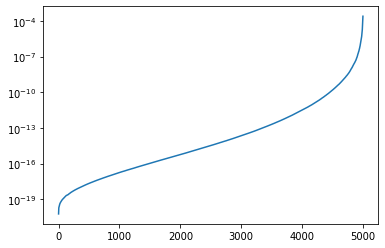

In [13]:
D, V = utils.get_eig(L, flag_gpu=False)
plt.plot(D)
plt.yscale('log')